In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np
import torch

from tqdm import tqdm
from scipy import stats

from src.utils import ratemap_collage, weighted_kde, SimpleDatasetMaker
from src.models import RecurrentSpaceNet, Decoder, End2End

plt.style.use("figures/project_style.mplstyle")

In [2]:
save_loc = "figures" # location for saving figures

In [3]:
## Training parameters
train_steps = 10000
timesteps = 10
bs = 32 # batch size

# Model parameters
n_in = 4 # Cartesian coordinates + 2 context
n_out = 100 # no. of spatial representations
scale = 0.15

In [4]:
# instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecurrentSpaceNet(n_in = n_in, n_out = n_out, corr_across_space= True,
                          scale = scale, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [5]:
genny = SimpleDatasetMaker() # use simple dataset

contexts = torch.tensor([[0,10],[10, 0]], device= device)
print(contexts.shape)

torch.Size([2, 2])


In [6]:
train_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps, device = device)

    c = contexts[torch.randint(len(contexts), size = (bs,))]
    # broadcast same context signal to all timesteps
    c = c[:,None]*torch.ones((1, timesteps - 1, 1), device = device) 
    
    inputs = (torch.cat((v, c), dim = -1), r[:,0])
    labels = (r[:, 1:], c)

    loss = model.train_step(x = inputs, y = labels, optimizer = optimizer)

    if i % 10 == 0:
        train_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

loss: 0.022652: 100%|██████████| 10000/10000 [01:24<00:00, 118.95it/s]


In [7]:
plt.figure(figsize=(4,4))
plt.semilogy(np.arange(len(train_history)), train_history, "-k")
plt.xlabel("Train Step")
plt.ylabel("Train Loss")
plt.savefig(f"{save_loc}/model_loss_history")

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x7fad65abb880> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 600x600 with 1 Axes>

In [8]:
# evaluate  model to visualize prediction error
model.to('cpu'), 
contexts = contexts.to('cpu')

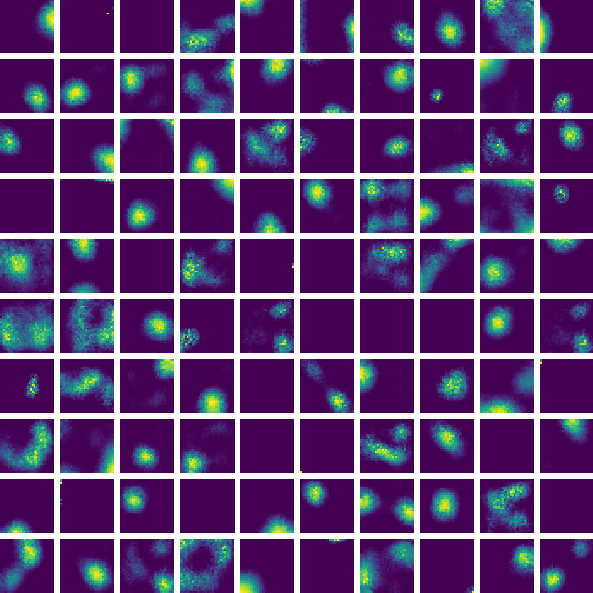

In [10]:
# visualize representations
n_plot = 5000 # number of plot trajectories
n_show = 100 # number of units to show
r, v = genny.generate_dataset(n_plot, timesteps)

# BSR 
input = torch.cat((v, contexts[1][None,None]*torch.ones(n_plot, timesteps-1, 1)), dim = -1)

p,_ = model.spatial_representation(input, model.p0(r[:,0])[None])
p = p.detach().numpy()
ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins = 32)
fig, ax = ratemap_collage(ratemaps[:n_show], cols = int(np.sqrt(n_show)), figsize = (4,4))
#plt.savefig(f"{save_loc}/rnn_representations")